In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [8]:
arctic_mix = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc"
alberto_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/alberto_ds.nc"
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"
mosaic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/mosaic_ds.nc"
#nice_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/nice_ds.nc"
HM_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/HM_ds.nc"
NN_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"

arctic_ds = xr.open_dataset(arctic_mix)
alberto_ds = xr.open_dataset(alberto_nc)
global_ds = pd.read_pickle(global_pkl)
global_nn = xr.open_dataset(global_nc)
mosaic_ds = xr.open_dataset(mosaic_nc)
#nice_ds = xr.open_dataset(nice_nc)
HM_ds = xr.open_dataset(HM_nc)
NN_ds = xr.open_dataset(NN_nc)

In [9]:
arctic_ds

<xarray.Dataset>
Dimensions:    (depth: 300, profile: 871, single: 1)
Coordinates:
    latitude   (depth, profile, single) float64 ...
    longitude  (depth, profile, single) float64 ...
  * depth      (depth) int64 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile, single
Data variables:
    TIME       (depth, profile, single) float64 ...
    eps        (depth, profile) float64 ...
    P          (depth, single) float64 ...
    S          (depth, profile) float64 ...
    T          (depth, profile) float64 ...
    z          (depth, single) float64 ...

In [30]:
def check_coords(data):
    if "latitude" not in data.coords:
        data = data.set_coords("latitude")
    if "longitude" not in data.coords:
        data = data.set_coords("longitude")
    if "time" not in data.coords:
        data = data.set_coords("time")
    if "depth" not in data.coords:
        data["depth"] = data.depth
    return data

In [31]:
alberto_ds

<xarray.Dataset>
Dimensions:    (depth: 69, profile: 351)
Coordinates:
  * depth      (depth) int64 0 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67 68
    longitude  (profile) float64 ...
    latitude   (profile) float64 ...
    year       int64 ...
    time       (profile) float64 ...
  * profile    (profile) int64 0 1 2 3 4 5 6 7 ... 344 345 346 347 348 349 350
Data variables:
    T          (depth, profile) float64 ...
    S          (depth, profile) float64 ...
    eps        (depth, profile) float64 ...
    P          (depth) int64 ...

In [32]:
#arctic_ds = arctic_ds.rename({"TIME":"time"})
ds_list = [alberto_ds, mosaic_ds, HM_ds, arctic_ds]
[alberto_ds, mosaic_ds, HM_ds, arctic_ds] = [check_coords(ds) for ds in ds_list]
# Select depth range up to 300 meters
ds_lost = [ds.sel(depth=slice(None, 69)) for ds in [alberto_ds, mosaic_ds, HM_ds, arctic_ds]]

In [33]:
mosaic_ds

<xarray.Dataset>
Dimensions:      (profile: 1684, depth: 69)
Coordinates:
    latitude     (profile) float64 ...
    longitude    (profile) float64 ...
    time         (depth, profile) float64 ...
  * profile      (profile) int64 351 352 353 354 355 ... 2031 2032 2033 2034
  * depth        (depth) int64 0 1 2 3 4 5 6 7 8 ... 60 61 62 63 64 65 66 67 68
Data variables: (12/41)
    stime        (profile) float64 ...
    gpstime      (depth, profile) float64 ...
    gpslat       (depth, profile) float64 ...
    gpslon       (depth, profile) float64 ...
    rtctime      (depth, profile) float64 ...
    P            (depth, profile) float64 ...
    ...           ...
    covar1       (depth, profile) float64 ...
    covar2       (depth, profile) float64 ...
    krho         (depth, profile) float64 ...
    Re_b         (depth, profile) float64 ...
    L_oz         (depth, profile) float64 ...
    krho_s       (depth, profile) float64 ...
Attributes:
    author:          Kirstin Schulz, Volker Mohrholz, Ilker Fer et al.
    contact:         kiki.schulz@utexas.edu
    created:         04-Apr-2022 15:42:44
    description:     MSS turbulent microstructure data MOSAiC
    cruise:          MOSAiC (Arctic Ocean), Sep 2019 - Sep 2020
    postprocessing:  MSP matlab toolbox (contact: volker.mohrholz@io-warnemue...

In [22]:
alberto_ds

<xarray.Dataset>
Dimensions:    (depth: 69, profile: 351)
Coordinates:
  * depth      (depth) int64 0 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67 68
    longitude  (profile) float64 ...
    latitude   (profile) float64 ...
    year       int64 ...
    time       (profile) float64 ...
  * profile    (profile) int64 0 1 2 3 4 5 6 7 ... 344 345 346 347 348 349 350
Data variables:
    T          (depth, profile) float64 ...
    S          (depth, profile) float64 ...
    eps        (depth, profile) float64 ...
    P          (depth) int64 ...

In [34]:
ds_combined = xr.concat(ds_list, dim='depth')

TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[datetime64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

In [20]:
# Define the new profile indices for each dataset
alberto_profiles = np.arange(len(alberto_ds.profile))
mosaic_profiles = np.arange(len(alberto_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile))
HM_profiles = np.arange(len(alberto_ds.profile) + len(mosaic_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile))
arctic_profiles = np.arange(len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile) + len(arctic_ds.profile))

# Rename the profile dimension to a new name for each dataset
alberto_ds = alberto_ds.rename(profile='alberto_profile')
mosaic_ds = mosaic_ds.rename(profile='mosaic_profile')
HM_ds = HM_ds.rename(profile='HM_profile')
arctic_ds = arctic_ds.rename(profile='arctic_profile')

# Reindex each dataset along the new profile dimension
alberto_ds = alberto_ds.reindex(alberto_profile=alberto_profiles)
mosaic_ds = mosaic_ds.reindex(mosaic_profile=mosaic_profiles)
HM_ds = HM_ds.reindex(HM_profile=HM_profiles)
arctic_ds = arctic_ds.reindex(arctic_profile=arctic_profiles)

# Rename the profile dimension back to 'profile'
alberto_ds = alberto_ds.rename(alberto_profile='profile')
mosaic_ds = mosaic_ds.rename(mosaic_profile='profile')
HM_ds = HM_ds.rename(HM_profile='profile')
arctic_ds = arctic_ds.rename(arctic_profile='profile')

# Concatenate the datasets along the 'profile' dimension
#ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='profile')

In [80]:
alberto_ds = alberto_ds.drop_vars('time')
mosaic_ds = mosaic_ds.drop_vars('time')
HM_ds = HM_ds.drop_vars('time')
arctic_ds = arctic_ds.drop_vars('time')

In [88]:
ds_list = [alberto_ds, mosaic_ds, HM_ds, arctic_ds]

# Merge the datasets
ds_merged = xr.merge(ds_list, compat='override')

# Assign coordinates to the merged dataset
ds_merged = ds_merged.assign_coords(
    latitude=lat,
    longitude=lon,
    depth=depth,
    profile=profile
)

ValueError: cannot reindex or align along dimension 'depth' because of conflicting dimension sizes: {440, 1903} (note: an index is found along that dimension with size=1903)

In [86]:
# define common coordinates across all datasets
coords = {"latitude": "lat", "longitude": "lon", "depth": "depth", "profile": "profile"}

In [87]:
ds = xr.merge(ds_list, compat='override', coords=coords)

TypeError: merge() got an unexpected keyword argument 'coords'

In [82]:
# Combine the datasets into one dataset
ds_list = [alberto_ds, mosaic_ds, HM_ds, arctic_ds]

# Create a common depth grid
depth_min = 0  # minimum depth
depth_max = 2000  # maximum depth
depth_step = 1  # depth step size
depth_grid = np.arange(depth_min, depth_max+depth_step, depth_step)

# Resample the data onto the common depth grid
for i in range(len(ds_list)):
    ds_list[i] = ds_list[i].interp(depth=depth_grid, method='linear')

# Concatenate the datasets along the depth dimension
ds_combined = xr.combine_by_coords(ds_list, compat='override')

MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'depth'}

In [83]:
xr.combine_by_coords([alberto_ds, mosaic_ds, HM_ds, arctic_ds], join="override", coords=['time', 'latitude', "depth", "profile"])

ValueError: cannot align objects with join='override' with matching indexes along dimension 'depth' that don't have the same size

In [73]:
ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='profile', join='override')

ValueError: cannot align objects with join='override' with matching indexes along dimension 'depth' that don't have the same size

In [72]:
# Determine unique depths across all datasets
unique_depths = np.unique(np.concatenate((alberto_ds.depth.values, mosaic_ds.depth.values, HM_ds.depth.values, arctic_ds.depth.values)))

# Reindex each dataset along the depth dimension
alberto_ds = alberto_ds.reindex(depth=unique_depths, method='nearest')
mosaic_ds = mosaic_ds.reindex(depth=unique_depths, method='nearest')
HM_ds = HM_ds.reindex(depth=unique_depths, method='nearest')
arctic_ds = arctic_ds.reindex(depth=unique_depths, method='nearest')

# Concatenate the datasets along the depth dimension

ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='depth')

ValueError: cannot reindex or align along dimension 'depth' because of conflicting dimension sizes: {440, 1903} (note: an index is found along that dimension with size=1903)

In [63]:
# Define the new profile indices for each dataset
alberto_profiles = np.arange(len(alberto_ds.profile))
mosaic_profiles = np.arange(len(alberto_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile))
HM_profiles = np.arange(len(alberto_ds.profile) + len(mosaic_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile))
arctic_profiles = np.arange(len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile) + len(arctic_ds.profile))

# Rename the profile dimension to a new name for each dataset
alberto_ds = alberto_ds.rename(profile='alberto_profile')
mosaic_ds = mosaic_ds.rename(profile='mosaic_profile')
HM_ds = HM_ds.rename(profile='HM_profile')
arctic_ds = arctic_ds.rename(profile='arctic_profile')

# Reindex each dataset along the new profile dimension
alberto_ds = alberto_ds.reindex(alberto_profile=alberto_profiles)
mosaic_ds = mosaic_ds.reindex(mosaic_profile=mosaic_profiles)
HM_ds = HM_ds.reindex(HM_profile=HM_profiles)
arctic_ds = arctic_ds.reindex(arctic_profile=arctic_profiles)

# Concatenate the datasets along the new profile dimension
ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='depth')

AttributeError: 'Dataset' object has no attribute 'profile'

In [8]:
# Merge datasets along the profile dimension
ds_merged = xr.merge([alberto_ds, mosaic_ds, HM_ds, arctic_ds], join='outer')

ValueError: cannot reindex or align along dimension 'profile' because of conflicting dimension sizes: {1684, 871, 78, 351} (note: an index is found along that dimension with size=78)

In [7]:
ds_concat = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim="depth")

# Ensure that each variable has a unique profile dimension
for varname in ds_concat.data_vars:
    ds_concat[varname] = ds_concat[varname].sel(profile=~ds_concat[varname].duplicated('profile'))

# Reindex each variable along the profile dimension
ds_concat = ds_concat.reindex(profile=np.unique(ds_concat.profile))

# Check that all variables have the same size along the profile dimension
assert all([ds_concat[varname].sizes['profile'] == ds_concat.sizes['profile'] for varname in ds_concat.data_vars])

ValueError: cannot reindex or align along dimension 'profile' because of conflicting dimension sizes: {1684, 871, 78, 351} (note: an index is found along that dimension with size=78)

In [6]:
ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim = "depth")

ValueError: cannot reindex or align along dimension 'profile' because of conflicting dimension sizes: {1684, 871, 78, 351} (note: an index is found along that dimension with size=78)

In [212]:
nice_ds

<xarray.Dataset>
Dimensions:    (profiles: 588, time: 588, LATITUDE: 588, LONGITUDE: 588,
                depth: 300)
Coordinates:
  * profiles   (profiles) float32 1.101e+03 1.102e+03 ... 1.687e+03 1.688e+03
  * time       (time) datetime64[ns] 2015-01-25T12:28:05.000003584 ... 2015-0...
  * LATITUDE   (LATITUDE) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
  * LONGITUDE  (LONGITUDE) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
  * depth      (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
Data variables:
    T          (depth, profiles) float64 ...
    S          (depth, profiles) float64 ...
    eps        (depth, profiles) float64 ...
    P          (depth) float64 ...
    latitude   (LATITUDE) float64 ...
    longitude  (LONGITUDE) float64 ...
Attributes: (12/34)
    platform_code:                 Drifting ice_camp near RV Lance
    site_code:                     588.0
    cruise_ID:                     N-ICE2015
    instrument_type:               MSS90L
    instrument:                    
    institution:                   Norwegian Polar Institute
    ...                            ...
    keywords_vocabulary:           EARTH SCIENCE>OCEANS>OCEAN TEMPERATURE>WAT...
    keywords:                      GCMD Science keywords
    iso_topic_category:            Oceans
    license:                       Norwegian Polar Institute 
    history:                       
    comment:                       Ocean microstructure dissipation, temperat...

In [211]:
nice_ds.T.shape

(300, 588)

In [218]:
arctic_ds

<xarray.Dataset>
Dimensions:    (depth: 300, profile: 871, single: 1)
Coordinates:
    latitude   (depth, profile, single) float64 ...
    longitude  (depth, profile, single) float64 ...
  * depth      (depth) int64 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile, single
Data variables:
    TIME       (depth, profile, single) float64 ...
    eps        (depth, profile) float64 ...
    P          (depth, single) float64 ...
    S          (depth, profile) float64 ...
    T          (depth, profile) float64 ...
    z          (depth, single) float64 ...

In [219]:
arctic_ds = arctic_ds.drop_dims('single')
arctic_ds

<xarray.Dataset>
Dimensions:  (depth: 300, profile: 871)
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile
Data variables:
    eps      (depth, profile) float64 ...
    S        (depth, profile) float64 ...
    T        (depth, profile) float64 ...

In [220]:
ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='experiment')

ValueError: cannot reindex or align along dimension 'profile' because of conflicting dimension sizes: {1684, 871, 78, 351} (note: an index is found along that dimension with size=78)

In [224]:
ds_combined = xr.merge([nice_ds, alberto_ds, mosaic_ds, HM_ds, arctic_ds], combine_by_coords='drop_conflicts')

TypeError: merge() got an unexpected keyword argument 'combine_by_coords'

In [186]:
ds_combined = xr.concat([nice_ds, alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim = "depth")

ValueError: cannot reindex or align along dimension 'profile' because of conflicting dimension sizes: {1684, 871, 78, 351} (note: an index is found along that dimension with size=78)

In [181]:
nice_ds = nice_ds.drop(["time", "LATITUDE", "LONGITUDE"])

## Visualise all the points

total amount of profiles is:  3001


/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:538: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:511: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


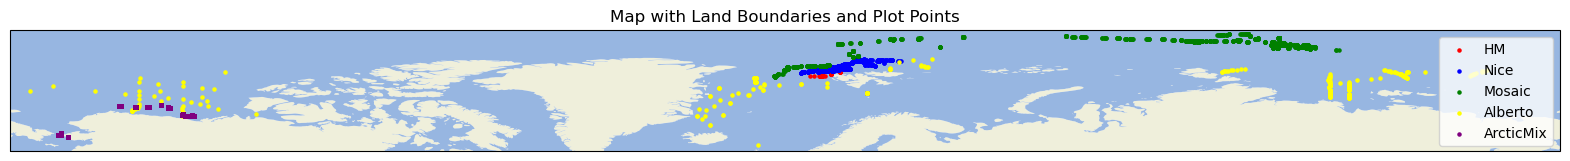

In [28]:
total_profiles = len(HM_ds["longitude"]) + len(nice_ds["longtiude"]) + len(mosaic_ds["longitude"]) + len(alberto_ds["longitude"]) + len(arctic_ds["longitude"])
print("total amount of profiles is: ", total_profiles)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(HM_ds["longitude"], HM_ds["latitude"], transform=ccrs.PlateCarree(), color='red', s=5, label = "HM")
ax.scatter(nice_ds["longtiude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label = "Nice")
ax.scatter(mosaic_ds["longitude"], mosaic_ds["latitude"], transform=ccrs.PlateCarree(), color='green', s=5, label = "Mosaic")
ax.scatter(alberto_ds["longitude"], alberto_ds["latitude"], transform=ccrs.PlateCarree(), color='yellow', s=5, label = "Alberto")
ax.scatter(arctic_ds["longitude"], arctic_ds["latitude"], transform=ccrs.PlateCarree(), color='purple', s=5, label = "ArcticMix")

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
ax.legend()
plt.show()

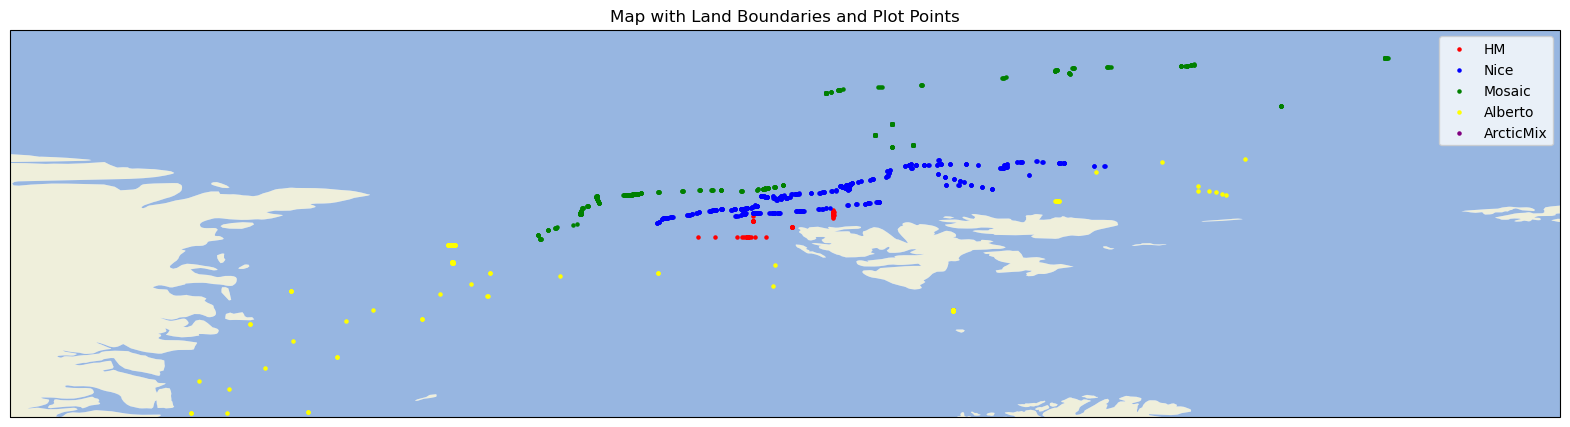

In [13]:
# focus on the Svalbard Islands
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(HM_ds["longitude"], HM_ds["latitude"], transform=ccrs.PlateCarree(), color='red', s=5, label = "HM")
ax.scatter(nice_ds["longtiude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label = "Nice")
ax.scatter(mosaic_ds["longitude"], mosaic_ds["latitude"], transform=ccrs.PlateCarree(), color='green', s=5, label = "Mosaic")
ax.scatter(alberto_ds["longitude"], alberto_ds["latitude"], transform=ccrs.PlateCarree(), color='yellow', s=5, label = "Alberto")
ax.scatter(arctic_ds["longitude"], arctic_ds["latitude"], transform=ccrs.PlateCarree(), color='purple', s=5, label = "ArcticMix")

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([-30, 50, 70, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
ax.legend()
plt.show()


In [23]:
HM_max_depths.append(HM_max_depths*2)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

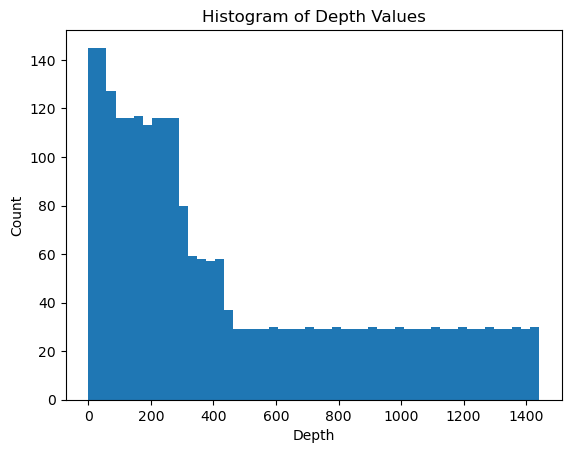

In [206]:
# Select the depth variable from each dataset
depth1 = arctic_ds['depth'].sel()
depth2 = alberto_ds['depth'].sel()
depth3 = nice_ds['depth'].sel()
depth4 = mosaic_ds['depth'].sel()
depth5 = HM_ds['depth'].sel()

# Concatenate the depth values into a single array
depth_values = np.concatenate([depth1.values, depth2.values, depth3.values, depth4.values, depth5.values])

# Plot a histogram of the combined depth values
plt.hist(depth_values, bins=50)
plt.xlabel('Depth')
plt.ylabel('Count')
plt.title('Histogram of Depth Values')
plt.show()

## Concatenate the datasets
Remember to show what dataset is from which cruise in this part of the processing

In [22]:
HM_max_depths = HM_ds.depth.values
combined_ds["cruise"] = "NICE"

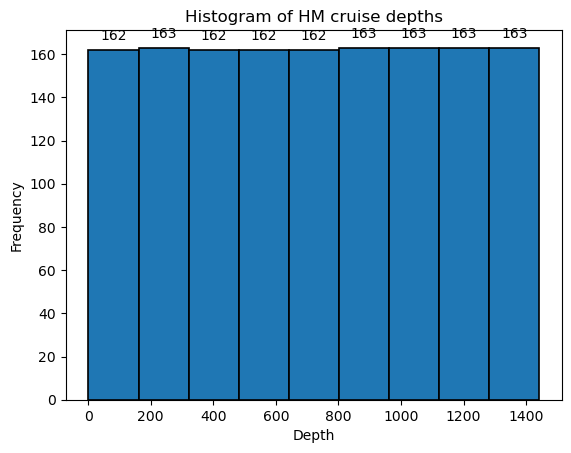

In [136]:
# take the max depth for every profile
max_depths = HM_ds.depth.values
fig, ax = plt.subplots()
n, bins, patches = plt.hist(max_depths, bins=9, edgecolor='black', linewidth=1.2)
# Add labels and title
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Histogram of HM cruise depths')

# Add text labels to each bin
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    ax.annotate(str(int(y)), xy=(x, y), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
# add cruise column so we know which data belongs to which


# From now on, pretend like nice_ds is the combined_ds


In [137]:
nice_ds

<xarray.Dataset>
Dimensions:    (profiles: 588, time: 588, LATITUDE: 588, LONGITUDE: 588,
                depth: 300)
Coordinates:
  * profiles   (profiles) float32 1.101e+03 1.102e+03 ... 1.687e+03 1.688e+03
  * time       (time) datetime64[ns] 2015-01-25T12:28:05.000003584 ... 2015-0...
  * LATITUDE   (LATITUDE) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
  * LONGITUDE  (LONGITUDE) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
  * depth      (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
Data variables:
    T          (depth, profiles) float64 ...
    S          (depth, profiles) float64 ...
    eps        (depth, profiles) float64 ...
    latitude   (LATITUDE) float64 ...
    longtiude  (LONGITUDE) float64 ...
Attributes: (12/34)
    platform_code:                 Drifting ice_camp near RV Lance
    site_code:                     588.0
    cruise_ID:                     N-ICE2015
    instrument_type:               MSS90L
    instrument:                    
    institution:                   Norwegian Polar Institute
    ...                            ...
    keywords_vocabulary:           EARTH SCIENCE>OCEANS>OCEAN TEMPERATURE>WAT...
    keywords:                      GCMD Science keywords
    iso_topic_category:            Oceans
    license:                       Norwegian Polar Institute 
    history:                       
    comment:                       Ocean microstructure dissipation, temperat...

In [254]:
combined_ds = arctic_ds

In [255]:
combined_ds

<xarray.Dataset>
Dimensions:  (depth: 300, profile: 871)
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile
Data variables:
    eps      (depth, profile) float64 ...
    S        (depth, profile) float64 ...
    T        (depth, profile) float64 ...

# Omit NaNs
omit NaNs for T,S,eps

In [261]:
def mask_nan(dataset):
    # Make sure there are no nans
    mask = np.isnan(dataset.T)*np.isnan(dataset.S)*np.isnan(dataset.eps)
    dataset["T"] = xr.where(mask,np.nan,dataset.T)
    dataset["S"] = xr.where(mask,np.nan,dataset.S)
    dataset["eps"] = xr.where(mask,np.nan,dataset.eps)
    return dataset

In [258]:
#mask = 1-(np.isnan(combined_ds.eps.values) | np.isnan(combined_ds.T.values) | np.isnan(combined_ds.S.values) )
# Make sure there are no nans
mask = np.isnan(arctic_ds.T)*np.isnan(arctic_ds.S)*np.isnan(arctic_ds.eps)
print(mask)
#combined_ds["T"] = xr.where(mask,np.nan,combined_ds.T)
#combined_ds["S"] = xr.where(mask,np.nan,combined_ds.S)
#combined_ds["eps"] = xr.where(mask,np.nan,combined_ds.S)

#combined_ds["T"] = combined_ds["T"][mask,:]
#combined_ds["S"] = combined_ds["S"][mask,:]
#combined_ds["eps"] = combined_ds["eps"][mask,:]
combined_ds['T'] = xr.where(mask,np.nan,combined_ds.T)
combined_ds['S'] = xr.where(mask,np.nan,combined_ds.S)
combined_ds['eps'] = xr.where(mask,np.nan,combined_ds.eps)

<xarray.DataArray (depth: 300, profile: 871)>
array([[False, False, False, ..., False, False, False],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile


## Calculate features like in Mashayek et al. (2021)

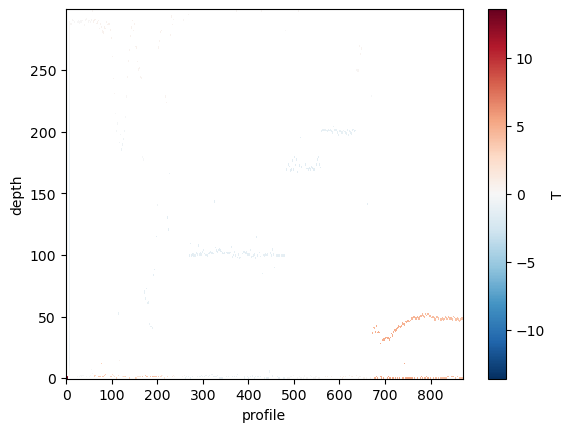

In [280]:
arctic_ds.T.plot()

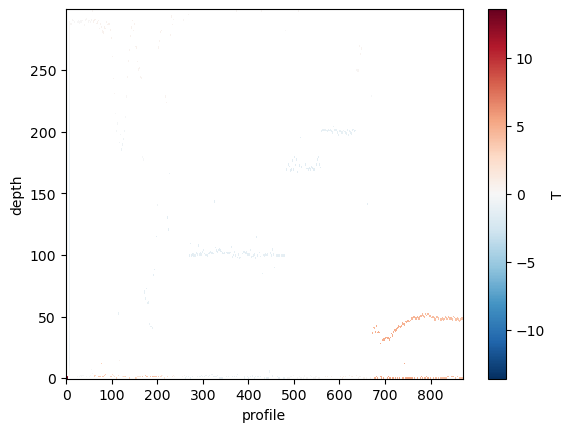

In [262]:
# arctic_ds
arctic_nan_ds = mask_nan(arctic_ds)
arctic_nan_ds.T.plot()

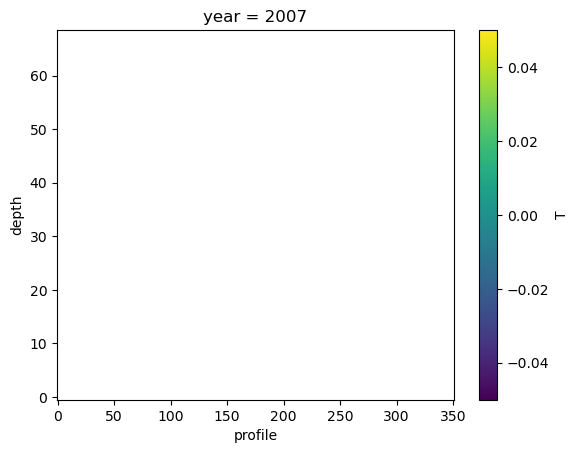

In [263]:
# alberto_ds
alberto_nan_ds = mask_nan(alberto_ds)
alberto_nan_ds.T.plot()

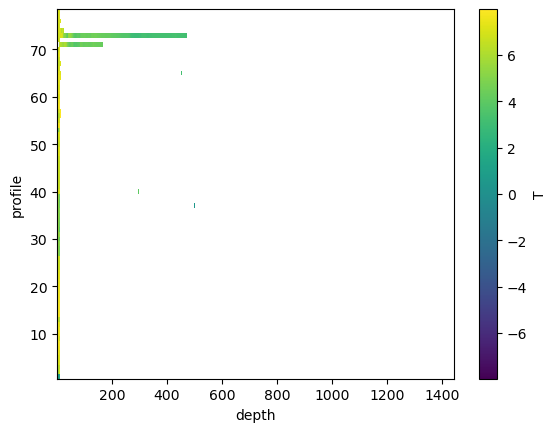

In [276]:
# HM_ds
HM_nan_ds = mask_nan(HM_ds)
HM_nan_ds.T.plot(cmap="viridis")

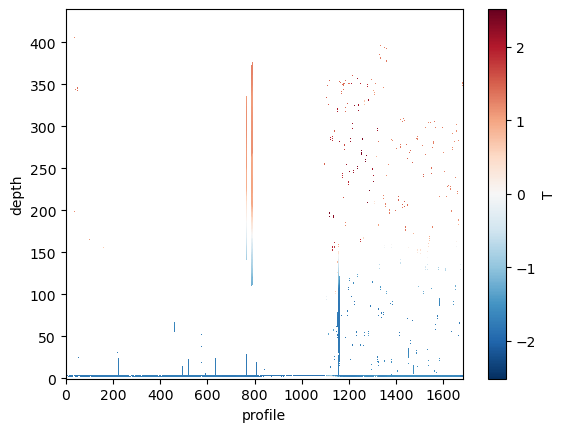

In [279]:
mosaic_ds.T.plot()

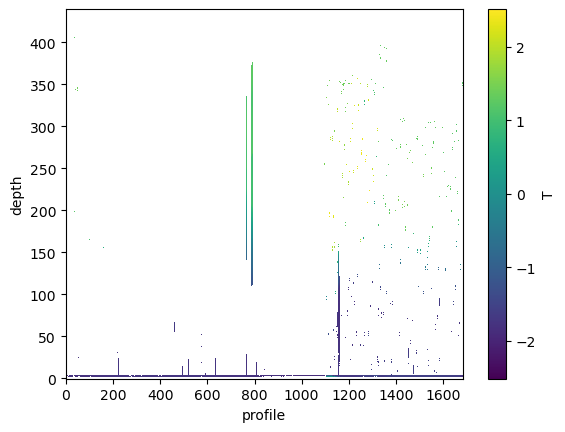

In [277]:
mosaic_nan_ds.T.plot(cmap="viridis")

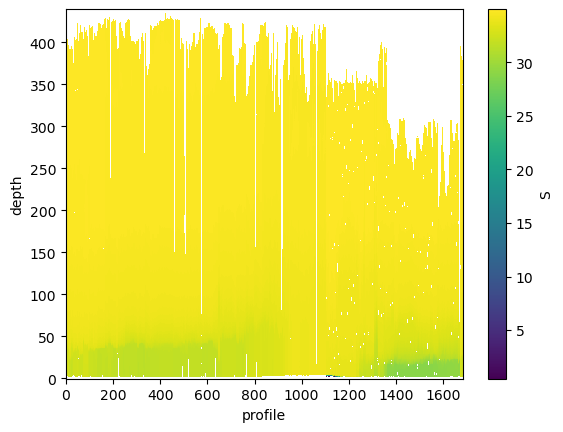

In [269]:
# mosaic_ds
mosaic_nan_ds = mask_nan(mosaic_ds)
mosaic_nan_ds.S.plot()

In [140]:
dataset = combined_ds
dataset["P"] =  dataset["depth"]
dataset['pot_temp'] = gsw.conversions.pt0_from_t(dataset.S,dataset.T, dataset.P)
dataset["CT"] = gsw.CT_from_pt(dataset['S'], dataset["pot_temp"])
dataset["kappa"] = gsw.kappa(dataset["S"],dataset["CT"], dataset['S'])
dataset

<xarray.Dataset>
Dimensions:    (profiles: 588, time: 588, LATITUDE: 588, LONGITUDE: 588,
                depth: 300)
Coordinates:
  * profiles   (profiles) float32 1.101e+03 1.102e+03 ... 1.687e+03 1.688e+03
  * time       (time) datetime64[ns] 2015-01-25T12:28:05.000003584 ... 2015-0...
  * LATITUDE   (LATITUDE) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
  * LONGITUDE  (LONGITUDE) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
  * depth      (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
Data variables:
    T          (depth, profiles) float64 nan nan nan nan ... 3.164 3.112 3.156
    S          (depth, profiles) float64 nan nan nan nan ... 34.93 34.9 34.89
    eps        (depth, profiles) float64 nan nan nan ... 7.041e-09 4.023e-09
    latitude   (LATITUDE) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
    longitude  (LONGITUDE) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
    P          (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
    pot_temp   (depth, profiles) float64 nan nan nan nan ... 3.144 3.093 3.137
    CT         (depth, profiles) float64 nan nan nan nan ... 3.142 3.092 3.136
    kappa      (depth, profiles) float64 nan nan nan ... 4.546e-10 4.545e-10
Attributes: (12/34)
    platform_code:                 Drifting ice_camp near RV Lance
    site_code:                     588.0
    cruise_ID:                     N-ICE2015
    instrument_type:               MSS90L
    instrument:                    
    institution:                   Norwegian Polar Institute
    ...                            ...
    keywords_vocabulary:           EARTH SCIENCE>OCEANS>OCEAN TEMPERATURE>WAT...
    keywords:                      GCMD Science keywords
    iso_topic_category:            Oceans
    license:                       Norwegian Polar Institute 
    history:                       
    comment:                       Ocean microstructure dissipation, temperat...

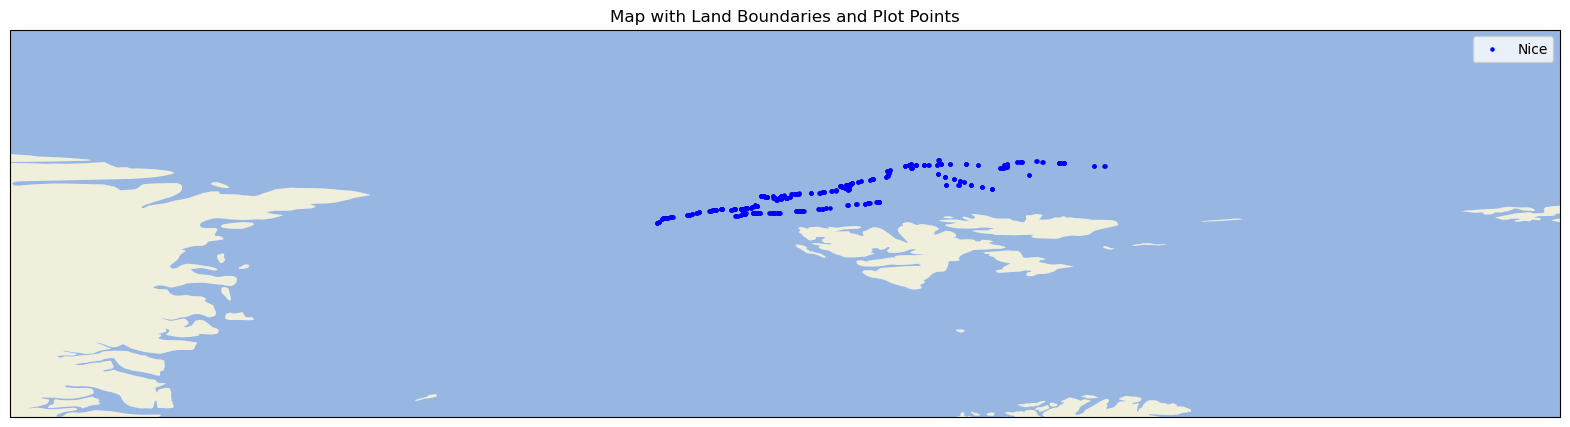

In [104]:
# focus on the Svalbard Islands
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(nice_ds["longtiude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label = "Nice")
# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([-30, 50, 70, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
ax.legend()
plt.show()

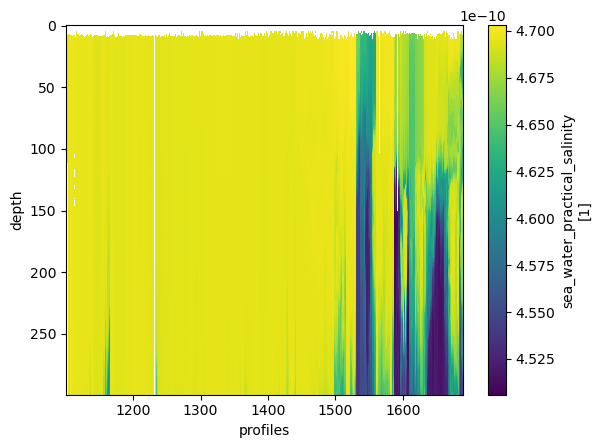

In [105]:
dataset.kappa.plot()
plt.gca().invert_yaxis()

In [144]:
# fix import
# from preprocessing.func_preprocessing import gws_conversions, TS_derivative
def gws_conversions(dataset):
    dataset["P"] = gsw.conversions.p_from_z(dataset["depth"],
                                            dataset["latitude"])
    print(dataset["P"].shape)
   # dataset['pot_temp'] = gsw.conversions.pt0_from_t(dataset.S,
         #                                            dataset.T, dataset.P)
    # calculate Conservative Temperature from potential temperature
   # dataset["CT"] = gsw.CT_from_pt(dataset['S'], dataset["pot_temp"])
    # calculate kappa using gsw_kappa function
   # dataset["kappa"] = gsw.kappa(dataset["S"],
     #                            dataset["CT"], dataset['S'])
    # calculate N^2 which is calculated for pressure midpoints
    #N2, p_mid = gsw.Nsquared(dataset["S"].expand_dims(dim="new_axis", axis=-1), dataset["CT"], dataset["P"],
    #                         dataset["latitude"])
    #dataset['N2'] = (('DEPTH_MID',), N2)
    #dataset['DEPTH_MID'] = p_mid
   # dataset['insitu_T'] = dataset["T"]
  #  dataset["T"] = dataset["pot_temp"]
    return dataset


def TS_derivative(dataset):
  dataset["dTdz"] = dataset.T.differentiate('depth')
  dataset['dSdz'] = dataset.S.differentiate('depth')
  return dataset

In [145]:
combined_ds = gws_conversions(combined_ds)
combined_ds = TS_derivative(combined_ds)
combined_ds

(300, 588)


<xarray.Dataset>
Dimensions:    (profiles: 588, time: 588, LATITUDE: 588, LONGITUDE: 588,
                depth: 300)
Coordinates:
  * profiles   (profiles) float32 1.101e+03 1.102e+03 ... 1.687e+03 1.688e+03
  * time       (time) datetime64[ns] 2015-01-25T12:28:05.000003584 ... 2015-0...
  * LATITUDE   (LATITUDE) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
  * LONGITUDE  (LONGITUDE) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
  * depth      (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
Data variables:
    T          (depth, profiles) float64 nan nan nan nan ... 3.164 3.112 3.156
    S          (depth, profiles) float64 nan nan nan nan ... 34.93 34.9 34.89
    eps        (depth, profiles) float64 nan nan nan ... 7.041e-09 4.023e-09
    latitude   (LATITUDE) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
    longitude  (LONGITUDE) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
    P          (depth, LATITUDE) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    pot_temp   (depth, profiles) float64 nan nan nan nan ... 3.144 3.093 3.137
    CT         (depth, profiles) float64 nan nan nan nan ... 3.142 3.092 3.136
    kappa      (depth, profiles) float64 nan nan nan ... 4.546e-10 4.545e-10
    dTdz       (depth, profiles) float64 nan nan nan ... -0.001853 0.02402 0.113
    dSdz       (depth, profiles) float64 nan nan nan ... -0.001192 0.001974
Attributes: (12/34)
    platform_code:                 Drifting ice_camp near RV Lance
    site_code:                     588.0
    cruise_ID:                     N-ICE2015
    instrument_type:               MSS90L
    instrument:                    
    institution:                   Norwegian Polar Institute
    ...                            ...
    keywords_vocabulary:           EARTH SCIENCE>OCEANS>OCEAN TEMPERATURE>WAT...
    keywords:                      GCMD Science keywords
    iso_topic_category:            Oceans
    license:                       Norwegian Polar Institute 
    history:                       
    comment:                       Ocean microstructure dissipation, temperat...

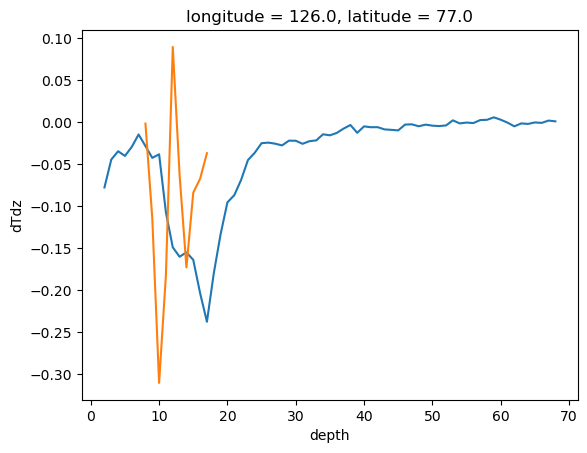

In [166]:
alberto_ds = TS_derivative(alberto_ds)
alberto_ds.dTdz.mean(dim="profile").plot()
alberto_ds.dTdz[:,6].plot()

In [121]:
combined_ds = combined_ds.rename({"longtiude": "longitude"})

In [122]:
combined_ds.to_netcdf("verwijder.nc")

## Neutral density

In [225]:
gamma_arctic = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data_exploration/gamma_processing/gamma_arctic.nc"
gamma_arctic_nc = xr.open_dataset(gamma_arctic)
gamma_arctic_nc

<xarray.Dataset>
Dimensions:  (depth: 300, profile: 871)
Dimensions without coordinates: depth, profile
Data variables:
    data     (depth, profile) float64 ...

In [230]:
arctic_ds

<xarray.Dataset>
Dimensions:  (depth: 300, profile: 871)
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile
Data variables:
    eps      (depth, profile) float64 ...
    S        (depth, profile) float64 ...
    T        (depth, profile) float64 ...

In [231]:
arctic_final = xr.concat([arctic_ds, gamma_arctic_nc], dim = "profile")

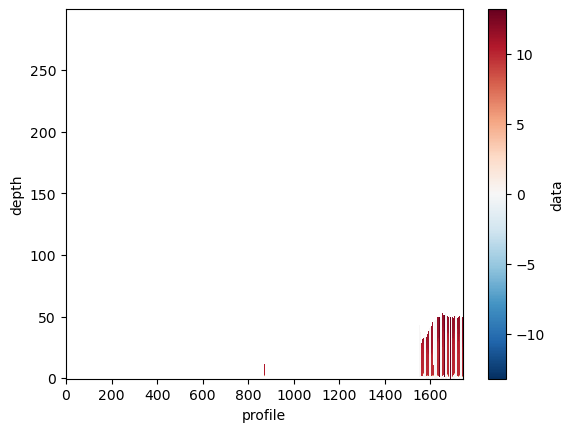

In [235]:
arctic_final.data.plot()

In [232]:
arctic_ds

<xarray.Dataset>
Dimensions:  (depth: 300, profile: 871)
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile
Data variables:
    eps      (depth, profile) float64 ...
    S        (depth, profile) float64 ...
    T        (depth, profile) float64 ...

## To do
- sort and omit NaNs
- profile, maybe can rename
- gamma and N2